# Artificial Neural Networks and Deep Learning - Homework 1

- Team: Bio.log(y)
- Members: Luca Lepore, Arianna Rigamonti, Michele Sala, Jacopo Libero Tettamanti 

---

## Image pre-processing 

### ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
#!pip install keras-cv
import keras_cv.layers as cv_layers

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"Tensor flow version: {tf.__version__}")
print(f"Kras version: {tfk.__version__}")

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from ipywidgets import interact, IntSlider, Dropdown
from tensorflow.keras.utils import to_categorical
import plotly.express as px
import imagehash

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensor flow version: 2.16.1
Kras version: 3.3.3


## ⏳ Load Data

In [2]:
# Load your dataset
data = np.load('/kaggle/input/training-set-npz/training_set.npz')
X = data['images']
y = data['labels']

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Save unique labels
unique_labels = list(labels.values())
print(f'Unique labels: {unique_labels}')

Unique labels: ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']


In [3]:
# Check the shape of the loaded images
print(f"Loaded images shape: {X.shape}")
print(f"Loaded labels shape: {y.shape}")
print(f"Min value: {X.min()}, Max value: {X.max()}")

Loaded images shape: (13759, 96, 96, 3)
Loaded labels shape: (13759, 1)
Min value: 0, Max value: 255


## 🔎 Inspect Data

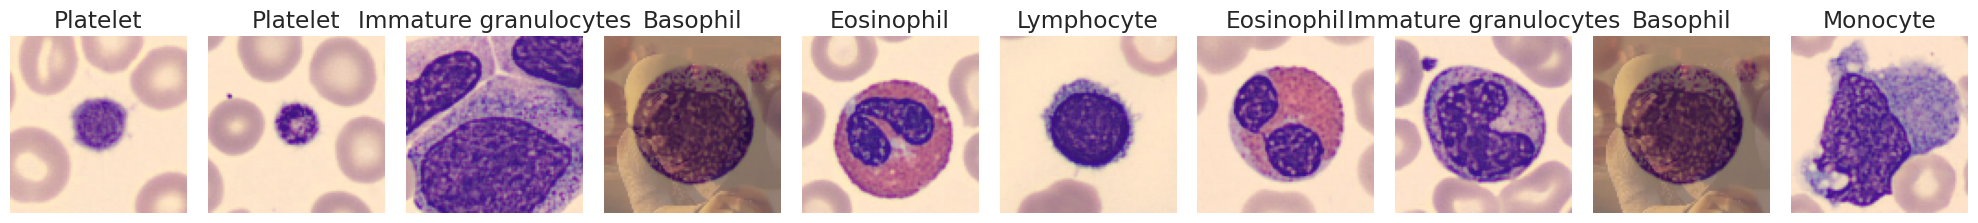

In [4]:
# Set a random seed for reproducibility
random.seed(seed)

# Visualize sample images
num_img = 10
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(X[idx], cmap='gray', vmin=0, vmax=255)
    ax.set_title(f'{labels[y[idx][0]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Dataset size: 13759 images
Occurrences of target classes:
digit
6    2530
1    2381
3    2226
7    1843
5    1393
2    1285
0    1052
4    1049
Name: count, dtype: int64
Unique class labels: [0 1 2 3 4 5 6 7]


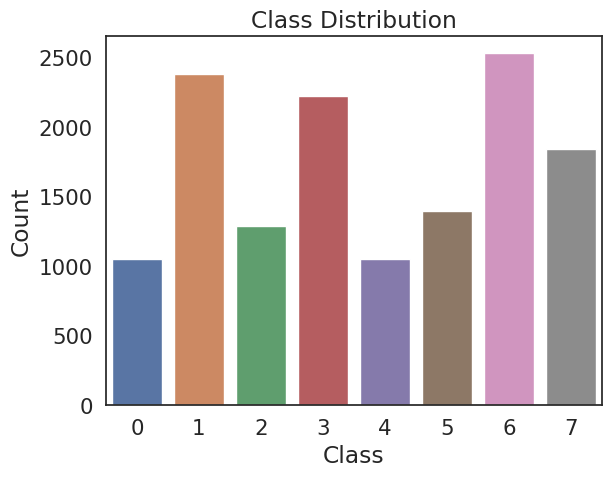

In [5]:
# Inspect the target
print(f'Dataset size: {len(X)} images')
print('Occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

# Flatten the y array to a 1D array
y_flat = y.flatten()

# Check unique class labels
print("Unique class labels:", np.unique(y_flat))

# Show class distribution
sns.countplot(x=y_flat)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## 🔄 Process Data

### Delete duplicated images

Identical images found.
Total number of images: 13759
Number of unique images: 11953
Number of duplicate images: 1806
Image 120 has 1 duplicates.


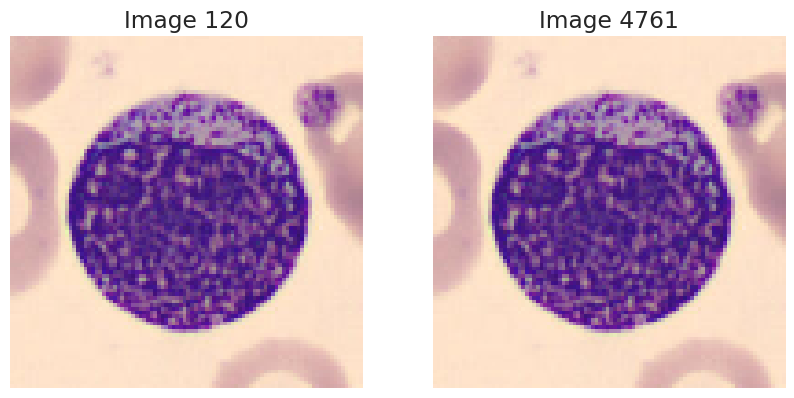

Image 810 has 1 duplicates.


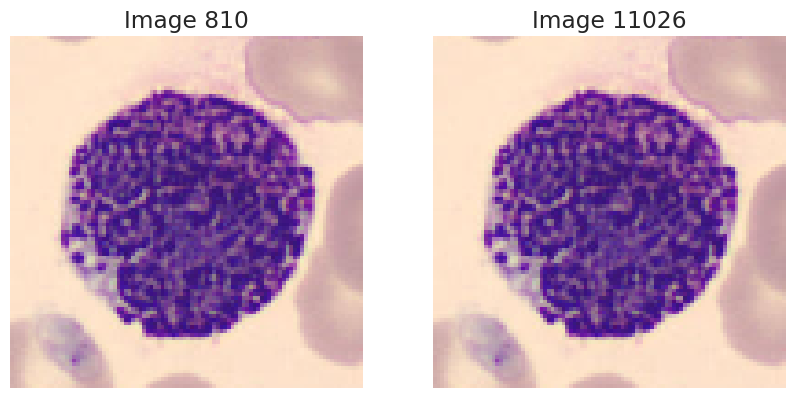

Image 1074 has 1 duplicates.


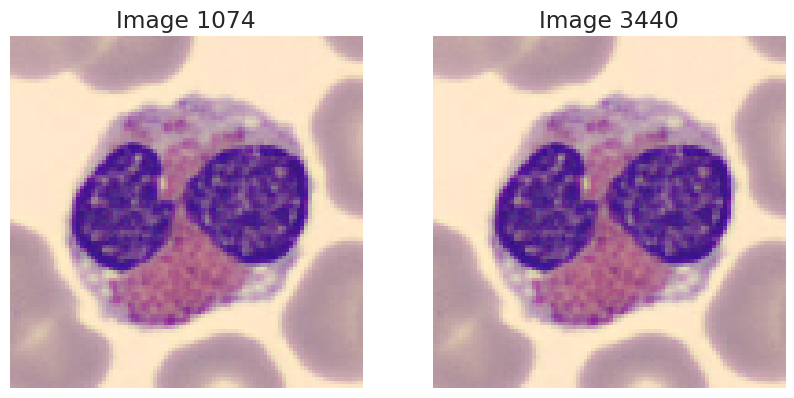

Image 3052 has 1 duplicates.


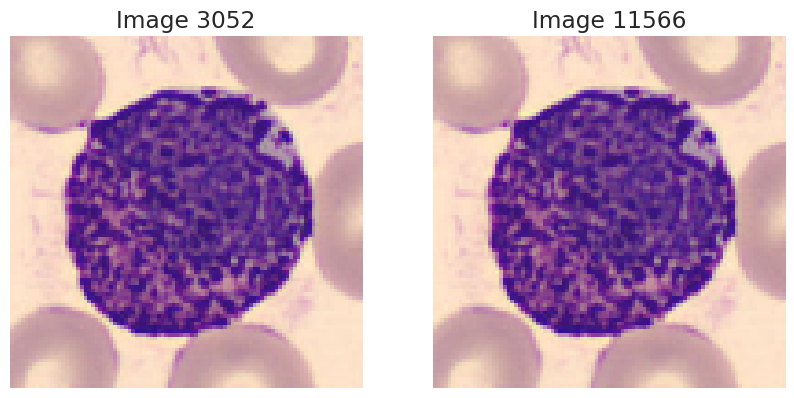

Image 3328 has 1 duplicates.


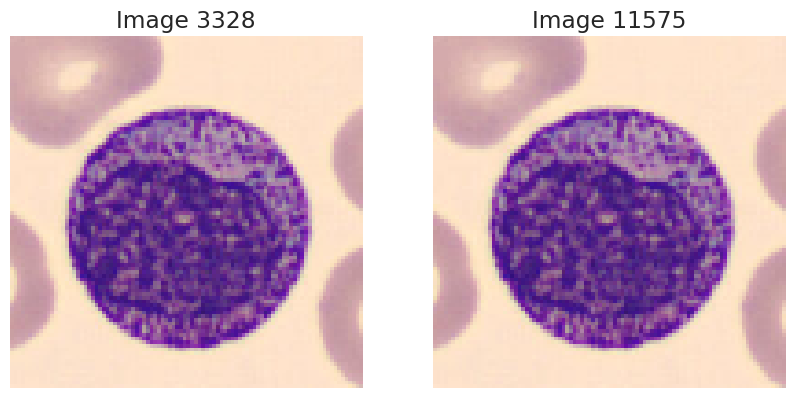

Image 5466 has 1 duplicates.


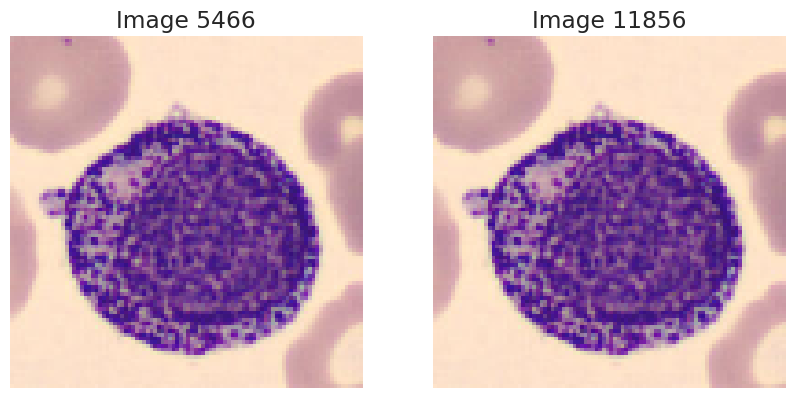

Image 7953 has 1 duplicates.


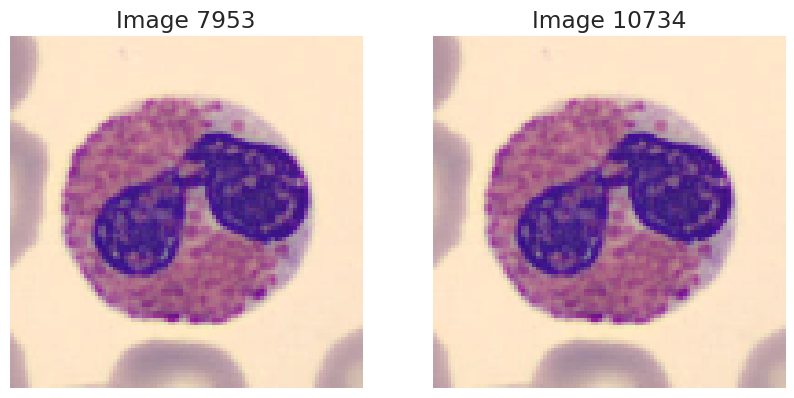

Image 8117 has 1 duplicates.


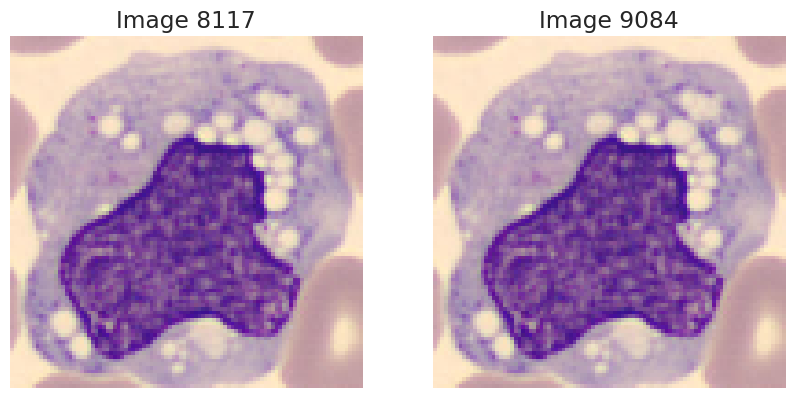

Image 11959 has 1599 duplicates.


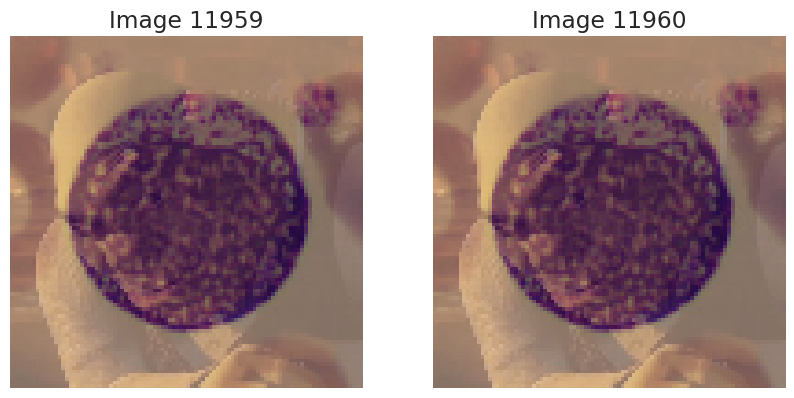

Image 13559 has 199 duplicates.


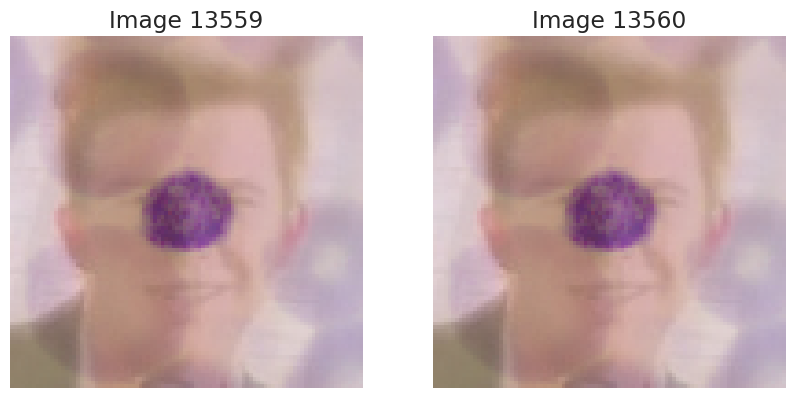

In [6]:
# Function to convert a numpy array into a PIL Image object
def numpy_to_pil(image_array):
    return Image.fromarray(image_array)

# Calculate the perceptual hash for each image
hashes = [imagehash.phash(numpy_to_pil(image)) for image in X]

# Check if there are identical images
unique_hashes = set(hashes)
if len(unique_hashes) == len(hashes):
    print("No identical images found.")
else:
    print("Identical images found.")
    print("Total number of images:", len(hashes))
    print("Number of unique images:", len(unique_hashes))
    print("Number of duplicate images:", len(hashes) - len(unique_hashes))

# Identify and visualize identical images
hash_dict = {}
for idx, h in enumerate(hashes):
    if h in hash_dict:
        hash_dict[h].append(idx)
    else:
        hash_dict[h] = [idx]
identical_images = {k: v for k, v in hash_dict.items() if len(v) > 1}

for h, indices in identical_images.items():
    print(f"Image {indices[0]} has {len(indices) - 1} duplicates.")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(X[indices[0]])
    axes[0].set_title(f'Image {indices[0]}')
    axes[0].axis('off')

    axes[1].imshow(X[indices[1]])
    axes[1].set_title(f'Image {indices[1]}')
    axes[1].axis('off')
    plt.show()

In [7]:
# Get the indices of duplicate images
indices_to_delete = [idx for sublist in identical_images.values() for idx in sublist[1:]]

# Create a set for faster operations
indices_to_delete_set = set(indices_to_delete)

# Keep only the indices that are not in the duplicate images
indices_to_keep = [idx for idx in range(len(X)) if idx not in indices_to_delete_set]

# Filter X and y to retain only unique images
X = X[indices_to_keep]
y = y[indices_to_keep]

# Check the new size of the dataset
print(f"New dataset size: {len(X)} images and {len(y)} labels")

New dataset size: 11953 images and 11953 labels


In [8]:
# Flatten labels and apply one-hot encoding
y_flat = y.flatten()  # Flatten the labels
y_one_hot = to_categorical(y_flat, num_classes=len(labels))  # Apply one-hot encoding

# First split: Separate into training+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_one_hot, test_size=0.2, random_state=seed, stratify=y_flat
)

# Flatten the labels for the temporary set to stratify the second split
y_temp_flat = np.argmax(y_temp, axis=1)  # Convert one-hot encoded labels back to class indices

# Second split: Separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=seed, stratify=y_temp_flat
)  # 0.25 x 0.8 = 0.2 of the total dataset for validation

# Print the size of the sets
print(f"Training set size: {len(X_train)} images")
print(f"Validation set size: {len(X_val)} images")
print(f"Test set size: {len(X_test)} images")

Training set size: 7171 images
Validation set size: 2391 images
Test set size: 2391 images


### Image Augmentation

#### Training set

In [9]:
# Augmentation pipeline on training set
augmentation = tf.keras.Sequential([
    cv_layers.RandAugment(value_range=(0, 255), magnitude=0.7, augmentations_per_image=3),
    cv_layers.AugMix(value_range=(0, 255), severity=0.7, num_chains=3),
])

# Ensure X_train is a TensorFlow tensor
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)  # Convert labels to tensor

# Define how many augmented images per original
num_augmented_per_image = 3  # Number of augmented copies per original
batch_size = 64

# Initialize lists to store augmented images and corresponding labels
augmented_batches = []
augmented_labels = []

for i in range(0, X_train_tensor.shape[0], batch_size):
    # Extract a batch of images
    batch = X_train_tensor[i:i + batch_size]
    labels_batch = y_train_tensor[i:i + batch_size]  # Extract corresponding labels
    
    # For each original image, create augmented copies
    for _ in range(num_augmented_per_image):
        # Apply augmentation
        augmented_batch = augmentation(batch)
        
        # Append augmented batch to the list
        augmented_batches.append(augmented_batch.numpy())
        
        # Duplicate labels for each augmentation
        augmented_labels.append(labels_batch.numpy())

# Concatenate all augmented batches into a single array
X_train_augmented = np.concatenate(augmented_batches, axis=0)
y_train_augmented = np.concatenate(augmented_labels, axis=0)  # Concatenate duplicated labels

# Combine original training set with augmented images and labels (optional)
# X_train_combined = np.concatenate([X_train, X_train_augmented], axis=0)
# y_train_combined = np.concatenate([y_train, y_train_augmented], axis=0)

# Verify shapes
print(f"Original training set shape: {X_train.shape}")
print(f"Original labels shape: {y_train.shape}")
print(f"Augmented training set shape: {X_train_augmented.shape}")
print(f"Augmented labels shape: {y_train_augmented.shape}")
# print(f"Combined training set shape: {X_train_combined.shape}")
# print(f"Combined labels shape: {y_train_combined.shape}")
print(f"Augmented training set min value: {X_train_augmented.min()}, Augmented training set max value: {X_train_augmented.max()}")

Original training set shape: (7171, 96, 96, 3)
Original labels shape: (7171, 8)
Augmented training set shape: (21513, 96, 96, 3)
Augmented labels shape: (21513, 8)
Augmented training set min value: 0.0, Augmented training set max value: 255.00003051757812


In [10]:
# Clip values between 0 and 255
X_train_augmented = tf.clip_by_value(X_train_augmented, 0, 255).numpy()
print(f"After clipping - Augmented training set min value: {X_train_augmented.min()}, Augmented training set max value: {X_train_augmented.max()}")

After clipping - Augmented training set min value: 0.0, Augmented training set max value: 255.0


#### Validation set

In [11]:
# Augmentation pipeline on validation set
augmentation = tf.keras.Sequential([
    cv_layers.RandAugment(value_range=(0, 255), magnitude=0.7, augmentations_per_image=3),
    cv_layers.AugMix(value_range=(0, 255), severity=0.7, num_chains=3),
])

# Ensure X_val is a TensorFlow tensor
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)  # Convert labels to tensor

# Define how many augmented images per original
num_augmented_per_image = 3  # Number of augmented copies per original
batch_size = 64

# Initialize lists to store augmented images and corresponding labels
augmented_batches = []
augmented_labels = []

for i in range(0, X_val_tensor.shape[0], batch_size):
    # Extract a batch of images
    batch = X_val_tensor[i:i + batch_size]
    labels_batch = y_val_tensor[i:i + batch_size]  # Extract corresponding labels
    
    # For each original image, create augmented copies
    for _ in range(num_augmented_per_image):
        # Apply augmentation
        augmented_batch = augmentation(batch)
        
        # Append augmented batch to the list
        augmented_batches.append(augmented_batch.numpy())
        
        # Duplicate labels for each augmentation
        augmented_labels.append(labels_batch.numpy())

# Concatenate all augmented batches into a single array
X_val_augmented = np.concatenate(augmented_batches, axis=0)
y_val_augmented = np.concatenate(augmented_labels, axis=0)  # Concatenate duplicated labels

# Combine original validation set with augmented images and labels (optional)
# X_val_combined = np.concatenate([X_val, X_val_augmented], axis=0)
# y_val_combined = np.concatenate([y_val, y_val_augmented], axis=0)

# Verify shapes
print(f"Original validation set shape: {X_val.shape}")
print(f"Original labels shape: {y_val.shape}")
print(f"Augmented validation set shape: {X_val_augmented.shape}")
print(f"Augmented labels shape: {y_val_augmented.shape}")
# print(f"Combined validation set shape: {X_val_combined.shape}")
# print(f"Combined labels shape: {y_val_combined.shape}")
print(f"Augmented validation set min value: {X_val_augmented.min()}, Augmented validation set max value: {X_val_augmented.max()}")

Original validation set shape: (2391, 96, 96, 3)
Original labels shape: (2391, 8)
Augmented validation set shape: (7173, 96, 96, 3)
Augmented labels shape: (7173, 8)
Augmented validation set min value: 0.0, Augmented validation set max value: 255.00003051757812


In [12]:
# Clip values between 0 and 255
X_val_augmented = tf.clip_by_value(X_val_augmented, 0, 255).numpy()
print(f"After clipping - Augmented validation set min value: {X_val_augmented.min()}, Augmented test set max value: {X_val_augmented.max()}")

After clipping - Augmented validation set min value: 0.0, Augmented test set max value: 255.0


#### Test set

In [13]:
# Augmentation pipeline on test set
augmentation = tf.keras.Sequential([
    cv_layers.RandAugment(value_range=(0, 255), magnitude=1.0, augmentations_per_image=4),
    cv_layers.AugMix(value_range=(0, 255), severity=0.8, num_chains=4),
])

# Ensure X_test is a TensorFlow tensor
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)  # Convert labels to tensor

# Define how many augmented images per original
num_augmented_per_image = 4  # Number of augmented copies per original
batch_size = 64

# Initialize lists to store augmented images and corresponding labels
augmented_batches = []
augmented_labels = []

for i in range(0, X_test_tensor.shape[0], batch_size):
    # Extract a batch of images
    batch = X_test_tensor[i:i + batch_size]
    labels_batch = y_test_tensor[i:i + batch_size]  # Extract corresponding labels
    
    # For each original image, create augmented copies
    for _ in range(num_augmented_per_image):
        # Apply augmentation
        augmented_batch = augmentation(batch)
        
        # Append augmented batch to the list
        augmented_batches.append(augmented_batch.numpy())
        
        # Duplicate labels for each augmentation
        augmented_labels.append(labels_batch.numpy())

# Concatenate all augmented batches into a single array
X_test_augmented = np.concatenate(augmented_batches, axis=0)
y_test_augmented = np.concatenate(augmented_labels, axis=0)  # Concatenate duplicated labels

# Combine original test set with augmented images and labels (optional)
# X_test_combined = np.concatenate([X_test, X_test_augmented], axis=0)
# y_test_combined = np.concatenate([y_test, y_test_augmented], axis=0)

# Verify shapes
print(f"Original test set shape: {X_test.shape}")
print(f"Original labels shape: {y_test.shape}")
print(f"Augmented test set shape: {X_test_augmented.shape}")
print(f"Augmented labels shape: {y_test_augmented.shape}")
# print(f"Combined test set shape: {X_test_combined.shape}")
# print(f"Combined labels shape: {y_test_combined.shape}")
print(f"Augmented test set min value: {X_test_augmented.min()}, Augmented test set max value: {X_test_augmented.max()}")

Original test set shape: (2391, 96, 96, 3)
Original labels shape: (2391, 8)
Augmented test set shape: (9564, 96, 96, 3)
Augmented labels shape: (9564, 8)
Augmented test set min value: 0.0, Augmented test set max value: 255.00003051757812


In [14]:
# Clip values between 0 and 255
X_test_augmented = tf.clip_by_value(X_test_augmented, 0, 255).numpy()
print(f"After clipping - Augmented test set min value: {X_test_augmented.min()}, Augmented test set max value: {X_test_augmented.max()}")

After clipping - Augmented test set min value: 0.0, Augmented test set max value: 255.0


## 💾 Save Data

#### Training set

In [19]:
# Save the augmented dataset and corresponding labels in .npz format
np.savez_compressed('X_train_augmented_3x.npz', images=X_train_augmented, labels=y_train_augmented)

print("Augmented training set saved to 'X_train_augmented_3x.npz'")

Augmented training set saved to 'X_train_augmented.npz'


#### Validation set

In [20]:
# Save the augmented dataset and corresponding labels in .npz format
np.savez_compressed('X_val_augmented_3x.npz', images=X_val_augmented, labels=y_val_augmented)

print("Augmented validation set saved to 'X_val_augmented_3x.npz'")

Augmented validation set saved to 'X_val_augmented.npz'


#### Test sets

##### Without augmentation

In [21]:
# Save the dataset and corresponding labels in .npz format
np.savez_compressed('X_test.npz', images=X_test, labels=y_test)

print("Test set saved to 'X_test.npz")

Test set saved to 'X_test.npz


##### With augmentation

In [22]:
# Save the augmented dataset and corresponding labels in .npz format
np.savez_compressed('X_test_augmented_4x.npz', images=X_test_augmented, labels=y_test_augmented)

print("Augmented test set saved to 'X_test_augmented_4x.npz")

Augmented test set saved to 'X_test_augmented.npz
